In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from DataProcessing import *
from FeatureEngineering import *


C:\Users\Jeffrey Tsai\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
class Estimator:
    def __init__(self,train_df=None,Xtest_df=None,response_name=None,folds=None,
                 modelList=None,lossDict=None,lossStdDict=None):
        '''
        init method for salary linear estimation
        '''
        self.train_df = train_df
        self.Xtest_df = Xtest_df
        # split X features and reponse from train df
        self.Xtrain_df = self.train_df.drop(response_name,axis=1)
        self.folds = folds
        self.ytrain_df = self.train_df[response_name]
        self.modelList = modelList
        self.lossDict = lossDict
        self.lossStdDict = lossStdDict

    def _baseline_estimator(self,figsz=(10,6)):
        '''
        define naive baseline estimator as mean salary
        '''
        mean_ytrain = np.mean(self.ytrain_df)
        # assign constant ndarray 
        self.yhat_train_baseline = np.full(shape=(len(self.ytrain_df),1),fill_value=mean_ytrain)
        devs_train_baseline = self.ytrain_df - self.yhat_train_baseline
        self.mse_train_baseline = np.mean(np.square(devs_train_baseline))
        self.rmse_train_baseline = np.sqrt(self.mse_train_baseline)
        print('mse_sk:',mean_squared_error(self.ytrain_df,self.yhat_train_baseline))
        print('rmse_sk:',np.sqrt(mean_squared_error(self.ytrain_df,self.yhat_train_baseline)))

    def plot_loss(self,hyper_arr=None,train_loss_arr=None,val_loss_arr=None,figsz=(10,6),xlabel=None,ylabel=None,folds=None):
        '''
        visualize loss in loss_arr at each hyperparameter in hyper_arr
        '''
        f,ax = plt.subplots(figsize=figsz)
        ax.plot(hyper_arr,train_loss_arr,color='blue',label='train')
        ax.plot(hyper_arr,val_loss_arr,color='red',label='validation')
        ax.set(title='{}-Fold Cross-Validation Loss'.format(folds),xlabel=xlabel,ylabel=ylabel)
        ax.legend()#(loc='upper_left')
        
    def _tune_hyperparams(self,model=None,params=None,lossfunc='neg_mean_squared_error',figsz=(10,6),ylabel='MSE',plot_param='randomforestregressor__n_estimators'):
        '''
        method to tune model hyperparameters with GridSearchCV
        '''
        gs = GridSearchCV(model,param_grid=params,cv=self.folds,
                         scoring=lossfunc,return_train_score=True)
        gs.fit(self.Xtrain_df,self.ytrain_df)
        best_model = gs.best_estimator_
        best_score = gs.best_score_
        best_test_score_array = gs.cv_results_['mean_test_score']
        if lossfunc=='neg_mean_squared_error':
            best_score = -1.0*best_score
            best_test_score_array = -1.0*best_test_score_array
            scores_train = -1.0*gs.cv_results_['mean_train_score']
            scores_val = -1.0*gs.cv_results_['mean_test_score']
        else:
            best_score = best_score
            best_test_score_array = best_test_score_array
            scores_train = gs.cv_results_['mean_train_score']
            scores_val = gs.cv_results_['mean_test_score']
        print('scores_train:',scores_train)
        print('scores_val:',scores_val)
        print('tuned optimal hyperparmeter:',gs.best_params_)   
        print('gridsearch best score:',best_score)
        # viz loss vs. hyperparameters
        xs = params[plot_param]
        self.plot_loss(hyper_arr=xs,train_loss_arr=scores_train,val_loss_arr=scores_val,
                           figsz=figsz,xlabel=plot_param,ylabel=ylabel,folds=self.folds)
        # return hyperparameter search best model:    
        return best_model 
        
    def _train_estimator(self,estimator=None):
        '''
        train and cross validate linear estimator and return train mse,rmse
        '''
        # compute k-fold cross-validated neg_mse
        scores_array = cross_val_score(estimator,
                                      self.Xtrain_df,self.ytrain_df,
                                      scoring='neg_mean_squared_error',
                                      cv=self.folds)
        print(scores_array)
        #mse 
        cv_mse_mean = np.nanmean(-1.0*scores_array)
        cv_mse_std = np.std(scores_array)
        # rmse
        scores_array_rmse = np.sqrt(-1.0*scores_array)
        cv_rmse_mean = np.nanmean(-1.0*scores_array_rmse)
        cv_rmse_std = np.std(scores_array_rmse)
        return cv_mse_mean,cv_mse_std,cv_rmse_mean,cv_rmse_std
    
    def _train_summary(self,estimator,cv_mse_mean=None,cv_mse_std=None,cv_rmse_mean=None,cv_rmse_std=None):
        '''
        summarize estimator training results
        '''
        print('\n{}'.format(estimator))
        print('\ntrain {}-fold mean MSE={:,.2f}'.format(self.folds,cv_mse_mean))
        print('\ntrain {}-fold std MSE={:,.2f}'.format(self.folds,cv_mse_std))
        print('\ntrain {}-fold mean RMSE={:,.2f}'.format(self.folds,cv_rmse_mean))
        print('\ntrain {}-fold std RMSE={:,.2f}'.format(self.folds,cv_rmse_std))
    
    def _train_estimators(self):
        '''
        train estimators and report cross-validated mean loss
        '''
        for lm in self.modelList:
            cv_mse_mean,cv_mse_std,cv_rmse_mean,cv_rmse_std = self._train_estimator(lm)
            self.lossDict[lm] = cv_mse_mean
            self.lossStdDict[lm] = cv_mse_std 
            self._train_summary(lm,
                                cv_mse_mean=cv_mse_mean,cv_mse_std=cv_mse_std,
                                cv_rmse_mean=cv_rmse_mean,cv_rmse_std=cv_rmse_std)

#### Instantiate data object $data$

In [3]:
ordinalcodes = {'degree':{'NONE':0,'HIGH_SCHOOL':1,'BACHELORS':2,'MASTERS':3,
                          'DOCTORAL':4},
                'jobType':{'JANITOR':0,'JUNIOR':1,'SENIOR':2,'MANAGER':3,
                           'VICE_PRESIDENT':4,'CFO':5,'CTO':6,'CEO':7},
#                 'industry':{'EDUCATION':0,'SERVICE':1,'AUTO':2,'HEALTH':3,'WEB':4,'FINANCE':5,'OIL':6}
                'major':{'NONE':0,'LITERATURE':1,'BIOLOGY':2,'CHEMISTRY':3,
                         'PHYSICS':4,'COMPSCI':5,'MATH':6,'BUSINESS':7,'ENGINEERING':8},
               }


# from DataProcessing import * 
data = Data(fname_Xtrain='train_features.csv',fname_ytrain='train_salaries.csv',
         fname_Xtest='test_features.csv',
         columns_cat=['companyId','degree','industry','jobType','major'],
         columns_num=['milesFromMetropolis','yearsExperience'],
         ylabel='salary',joinId='jobId',ordinal_dict=ordinalcodes)

train_df = data._encode_categorical_features(data.train_df,ordinal_dict=None,nominal_cols=['companyId','industry','jobType'])    


#### Instantiate feature engineering object and compute grouped statistics as new features   

In [4]:
featureEng = FeatureEng(data_object=data) 
train_df = featureEng._compute_new_features(train_df,cat_columns=featureEng.data.columns_cat,
                                            num_columns=featureEng.data.columns_num,clean=True)
train_df.head()

,milesFromMetropolis,yearsExperience,jobId,salary,companyId,degree,industry,jobType,major,cat_group_min,...,milesFromMetropolis_quantile_salary_median,milesFromMetropolis_quantile_salary_mean,milesFromMetropolis_quantile_salary_max,milesFromMetropolis_quantile_salary_std,yearsExperience_quantile,yearsExperience_quantile_salary_min,yearsExperience_quantile_salary_median,yearsExperience_quantile_salary_mean,yearsExperience_quantile_salary_max,yearsExperience_quantile_salary_std
0,83,10,JOB1362684407687,130,31,3,3,1,6,98,...,97.0,100.813725,215,32.664245,1,34,97.0,100.813725,215,32.664245
1,73,3,JOB1362684407688,101,11,2,6,0,7,90,...,92.0,90.646192,203,33.695502,0,24,92.0,90.646192,203,33.695502
2,38,10,JOB1362684407689,137,48,1,3,7,8,116,...,114.0,115.997442,212,33.006953,1,48,114.0,115.997442,212,33.006953
3,17,8,JOB1362684407690,142,32,1,0,5,2,77,...,121.0,121.643735,211,33.136505,1,45,121.0,121.643735,211,33.136505
4,16,8,JOB1362684407691,163,60,0,2,7,8,94,...,118.0,119.155612,229,34.557913,1,44,118.0,119.155612,229,34.557913


#### Instantiate estimator object $m$

In [5]:
m = Estimator(train_df=shuffle(train_df[:50000]).drop(data.id,axis=1),Xtest_df=data.Xtest_df,response_name=data.ylabel,
              folds=5,modelList=[],lossDict={},lossStdDict={})

## RandomForestRegressor

#### Tune RandomForest *n_estimators* hyperparameter
- *n_estimators* is the number of trees in the forest
- the estimator becomes more flexible as *n_estimators* increases

scores_train: [ 47.88924102  45.95191403]
scores_val: [ 331.28063262  327.60213604]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 100, 'randomforestregressor__verbose': False}
gridsearch best score: 327.602136041


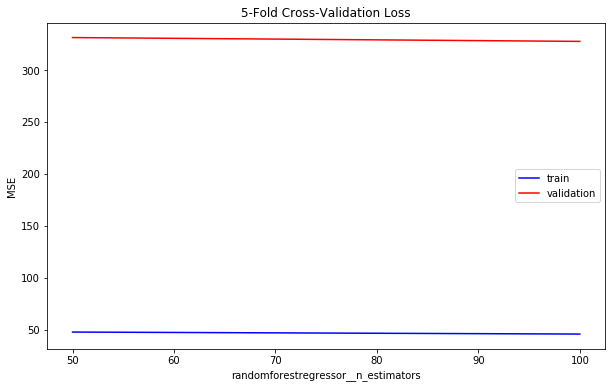

In [9]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__verbose':[False],   
                                                         'randomforestregressor__n_estimators':[50,100], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__n_estimators')   


#### Tune RandomForest *max_depth* hyperparameter:
- *max_depth* hyperparameter is the maximum depth of the tree; if *None*, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split* samples 
- optimal search returned  minimum validation loss at max depth value around 10

scores_train: [ 479.86778368  401.20379108  349.85258864  324.87394666  307.65985597
  290.81500167  270.00910472  243.73587988  214.60941947  183.14861286
  154.50535098  128.5767367   106.92889978   90.2863269    78.10055659
   68.72510511   62.51118011]
scores_val: [ 484.6924634   407.61712085  358.9577785   337.17012615  325.62935664
  320.84046703  320.11081743  320.58941454  321.67617229  323.20873925
  325.34050631  327.65632055  329.05557578  330.46219804  332.75588493
  334.2197458   333.96557174]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__verbose': False, 'randomforestregressor__max_depth': 9}
gridsearch best score: 320.110817432


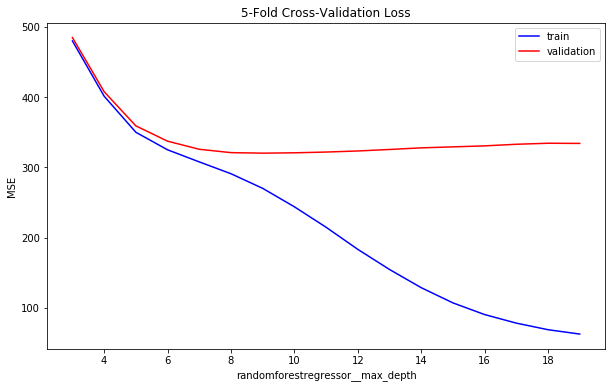

In [10]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':np.arange(3,20,1),  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_depth') 

#### Tune RandomForest min_samples_split hyperparameter:
- *min_samples_split* hyperparameter is the minimum number of samples required to split an internal node.
- smaller values of *min_samples_split* results in a more flexible estimator 
- optimal search returned minimum validation loss at *min_samples_split* value around 60

scores_train: [ 244.74639091  249.71593479  254.73718867  259.0813831   262.80450438
  266.17056292  269.42703348  272.59586126]
scores_val: [ 320.40043994  320.00174358  320.24773488  319.50018925  319.54218843
  319.59998546  319.30178728  319.78795654]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 65, 'randomforestregressor__verbose': False, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 10}
gridsearch best score: 319.30178728


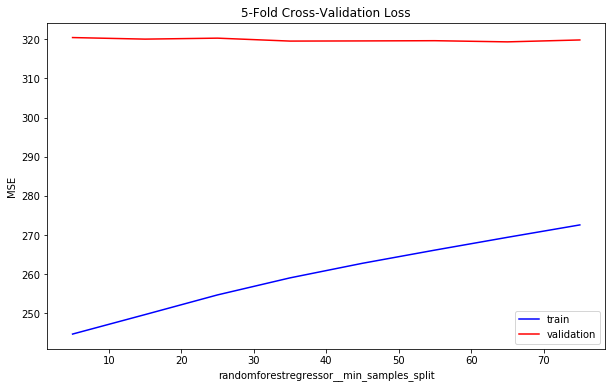

In [12]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':np.arange(5,76,10), 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_samples_split') 

#### Tune RandomForest *min_samples_leaf* hyperparameter
- *min_samples_leaf* hyperparameter is the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least *min_samples_leaf* training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- Smaller values of *min_samples_leaf* results in a more flexible estimator.
- GridSearch returned minimum validation loss at around *min_samples_leaf* value of 1.

scores_train: [ 268.50981218  288.61191351  305.24530424]
scores_val: [ 319.73043114  320.19146712  324.42997353]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__verbose': False, 'randomforestregressor__max_depth': 10}
gridsearch best score: 319.730431137


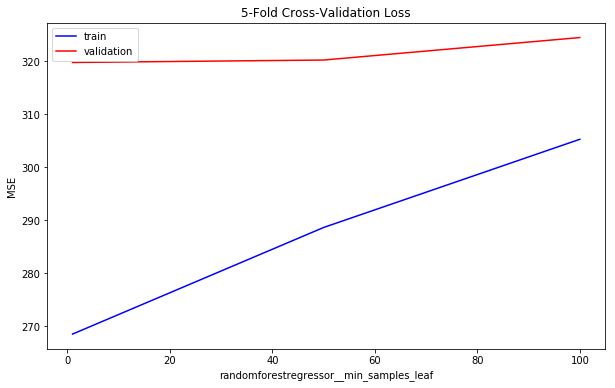

In [13]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1,50,100], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_samples_leaf') 

#### Tune RandomForest *min_weight_fraction_leaf* hyperparameter
- *min_weight_fraction_Leaf* hyperparameter is the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
- A lower *min_weight_fraction_leaf* value results in a more flexible model.
- GridSearch returned a minimum validation loss at the default value of *min_weight_fraction_leaf*=0.


scores_train: [ 268.73656781  328.2143697   483.98249772]
scores_val: [ 319.59677107  338.9710709   488.52513329]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 10, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__verbose': False}
gridsearch best score: 319.596771073


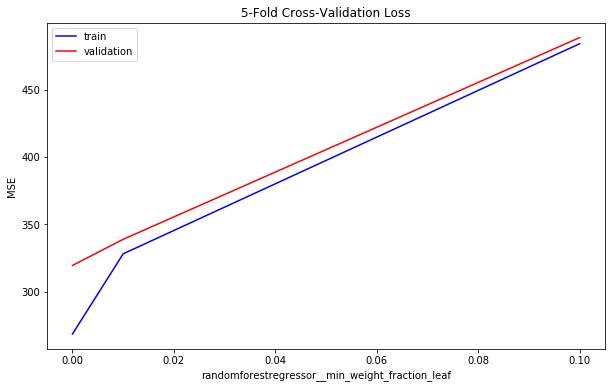

In [20]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0,1e-2,0.1], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_weight_fraction_leaf') 

#### Tune RandomForest *max_features* hyperparameter:
- max_features hyperparameter is the number of
- GridSearch returned minimum validation loss at around *max_features* value 0.625

scores_train: [ 363.2116952   306.66199273  289.81146854  284.32940706  278.49628149
  274.39765181  272.23999553  270.72640301  270.81677007  269.77194195]
scores_val: [ 395.98343903  343.04798932  327.08669171  323.24533237  319.64442649
  319.20483503  319.07574021  318.92848057  318.94775012  319.26831206]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_depth': 10, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__verbose': False}
gridsearch best score: 318.92848057


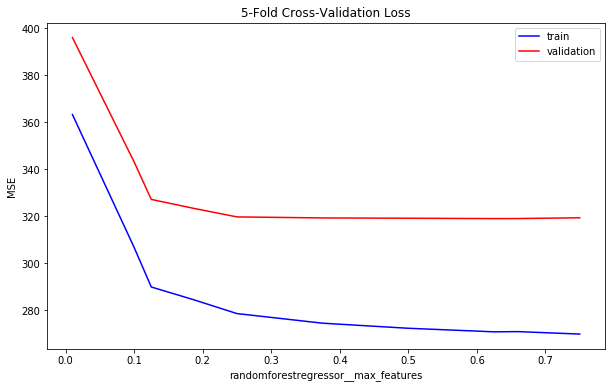

In [24]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.01,.1,.125,.1875,.25,.375,.5,.625,.66,.75], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_features') 

#### Tune RandomForest hyperparameter *max_leaf_nodes*
- *max_leaf_nodes* hyperparameter will grow trees with *max_leaf_nodes* in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- GridSearch returned minimum loss at *max_leaf_nodes*=*None*

scores_train: [ 435.92163602  308.80325649  308.32474505  261.08847389  270.72392497]
scores_val: [ 440.80917934  325.77119496  325.37726734  318.84850439  318.61946605]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__max_depth': 10, 'randomforestregressor__verbose': False}
gridsearch best score: 318.619466048


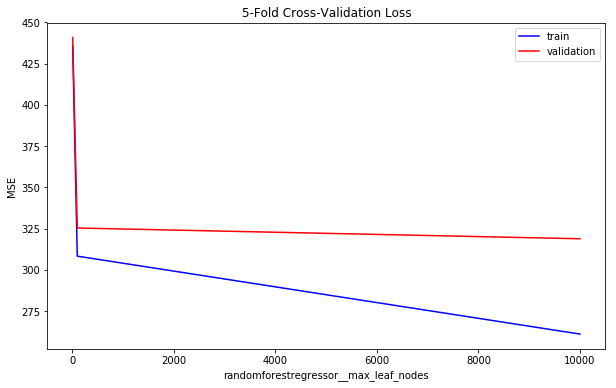

In [27]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.625], 
                                                         'randomforestregressor__max_leaf_nodes':[10,100,100,10000,None], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_leaf_nodes') 

#### Tune RandomForest *min_impurity_decrease* hyperparameter
- *min_impurity_decrease* specifies when a node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- a smaller value of *min_impurity_decrease* specifies a more flexible estimator.
- GridSearch returned minimal validation loss with *min_impurity_decrease*=0.

scores_train: [ 270.81000135  279.14954203  314.08847485]
scores_val: [ 319.02322976  319.43397737  328.56649831]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_depth': 10, 'randomforestregressor__verbose': False}
gridsearch best score: 319.023229757


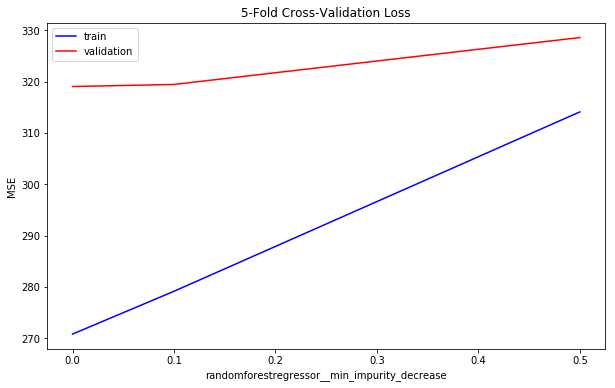

In [28]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.625], 
                                                         'randomforestregressor__max_leaf_nodes':[None], 
                                                         'randomforestregressor__min_impurity_decrease':[0,.1,.5], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_impurity_decrease') 

#### Tune RandomForest hyperparameter *bootstrap*
- *bootstrap* hyperparameter specifies whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.
- bootstrapped samples are preferred when building trees in the random forest
- We'll use the final hyperparameters specified below for RandomForestRegressor

scores_train: [ 270.92885501  258.17345319]
scores_val: [ 318.60964941  322.08097166]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__bootstrap': True, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_depth': 10, 'randomforestregressor__verbose': False}
gridsearch best score: 318.609649411


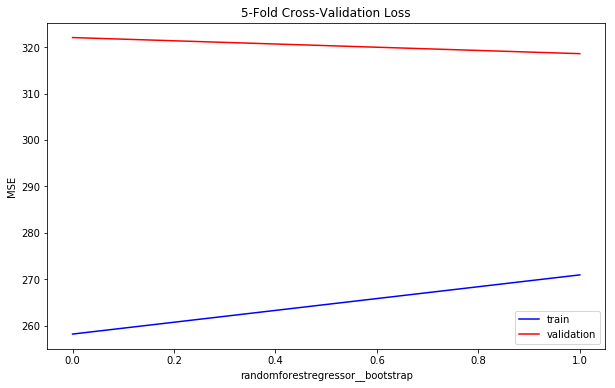

In [29]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.625], 
                                                         'randomforestregressor__max_leaf_nodes':[None], 
                                                         'randomforestregressor__min_impurity_decrease':[0], 
                                                         'randomforestregressor__bootstrap':[True,False], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__bootstrap') 

## GradientBoostingRegressor

#### Tune GradientBoostingRegressor *learning_rate* hyperparameter
- *learning_rate* shrinks the contribution of each tree by the *learning_rate*. There is a trade-off between *learning_rate* and *n_estimators*.
- optimal *learning_rate* is somewhere around 0.20

scores_train: [ 317.73068737  307.4087678   303.17573995  302.47757691  291.67149176]
scores_val: [ 326.93597234  321.36002984  321.04877873  320.12957847  325.47166824]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 320.129578472


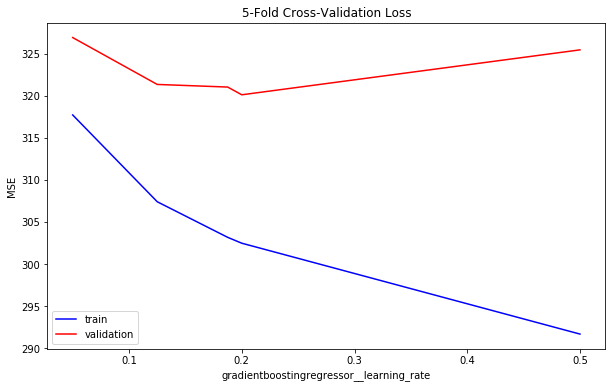

In [9]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.05,.125,.1875,.2,.5],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__learning_rate') 

#### Tune GradientBoostingRegressor *n_estimators* hyperparameter
- *n_estimators* is the number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
- GridSearch found optimal *n_estimators* value around 240.

scores_train: [ 905.13864164  302.47757691  290.92704573  287.20202921  274.59795609]
scores_val: [ 907.62375945  320.18679058  318.92424225  318.71211318  319.62742054]
tuned optimal hyperparmeter: {'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 318.712113181


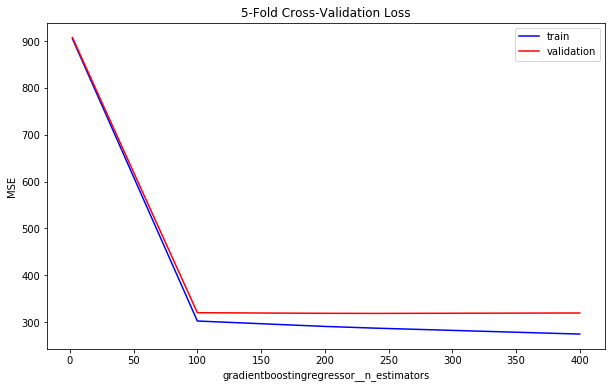

In [19]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[2,100,200,240,400],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__n_estimators') 

#### Tune GradientBoostingRegressor *subsample* hyperparameter
- *subsample* controls the fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. *subsample* interacts with the parameter *n_estimators*. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
- GridSearch returned optimal *subsample* value of 1 (no variance regulation)

scores_train: [ 491.93797397  288.7611448   287.20202921]
scores_val: [ 517.13220091  322.70811943  318.74018066]
tuned optimal hyperparmeter: {'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 318.740180662


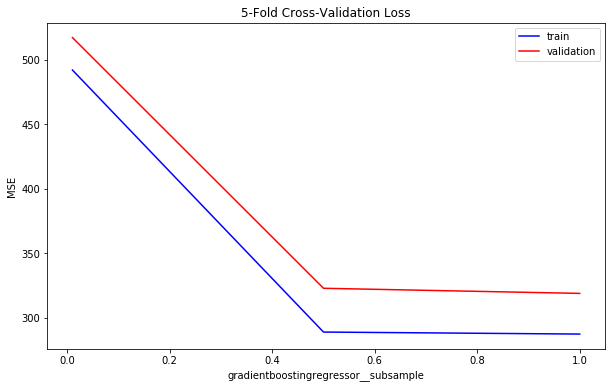

In [23]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[.01,.5,1],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__subsample') 

#### Tune GradientBoostingRegressor *min_samples_split* hyperparameter
- The minimum number of samples required to split an internal node: If *int*, then consider *min_samples_split* as the minimum number. If *float*, then *min_samples_split* is a fraction and *ceil(min_samples_split * n_samples)* are the minimum number of samples for each split.
- Minimal validation loss was maintained with *min_samples_split* value of 2. 

scores_train: [ 287.69145432  287.82376428]
scores_val: [ 318.76265537  319.05250762]
tuned optimal hyperparmeter: {'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__learning_rate': 0.2, 'gradientboostingregressor__min_samples_split': 2}
gridsearch best score: 318.762655373


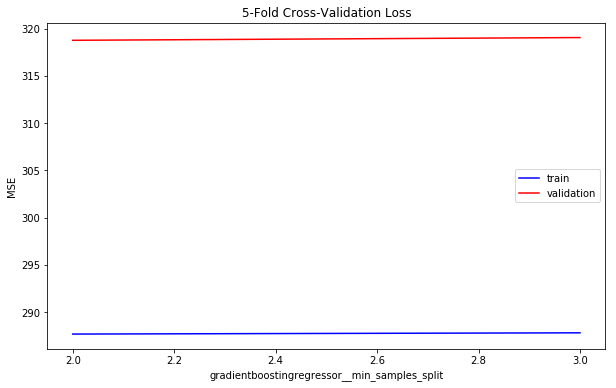

In [17]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2,3],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_samples_split') 

#### Tune GradientBoostingRegressor *min_samples_leaf* hyperparameter
- *min_samples_leaf* hyperparameter is the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least *min_samples_leaf* training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- GridSearch returned minimal validation loss at arond *min_samples_leaf*=200. 

scores_train: [ 287.51550601  293.40668375  295.75927564]
scores_val: [ 319.13634221  317.57609285  317.95400203]
tuned optimal hyperparmeter: {'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__min_samples_leaf': 200, 'gradientboostingregressor__learning_rate': 0.2, 'gradientboostingregressor__min_samples_split': 2}
gridsearch best score: 317.576092853


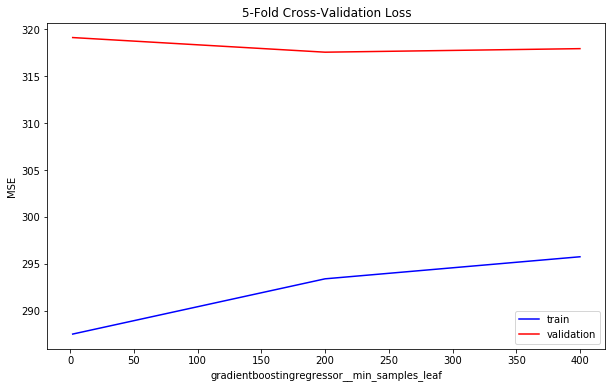

In [24]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2],
                                                         'gradientboostingregressor__min_samples_leaf':[2,200,400], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_samples_leaf') 

#### Tune GradientBoostingRegressor *min_weight_fraction_leaf*
- Hyperparameter *min_weight_fraction_leaf* is the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when *sample_weight* is not provided.
- The *min_weigh_fraction_leaf* default value of zero is optimal. 

scores_train: [  293.40668375   295.75927564  1210.96974747]
scores_val: [  317.57609285   317.95400203  1210.1519725 ]
tuned optimal hyperparmeter: {'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__min_samples_leaf': 200, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 317.576092853


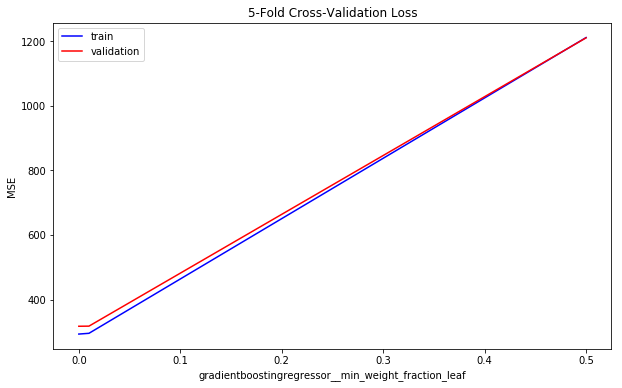

In [25]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2],
                                                         'gradientboostingregressor__min_samples_leaf':[200], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0,.01,.5], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_weight_fraction_leaf') 

#### Tune GradientBoostingRegressor *max_depth* hyperparameter
- *max_depth* specifies the maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. The best value depends on the interaction of the input variables.
- GridSearch determined optimal *max_depth* value is 3.

scores_train: [ 293.40668375  104.72386258  104.72386258]
scores_val: [ 317.57609285  354.29816021  354.29816021]
tuned optimal hyperparmeter: {'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_leaf': 200, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 317.576092853


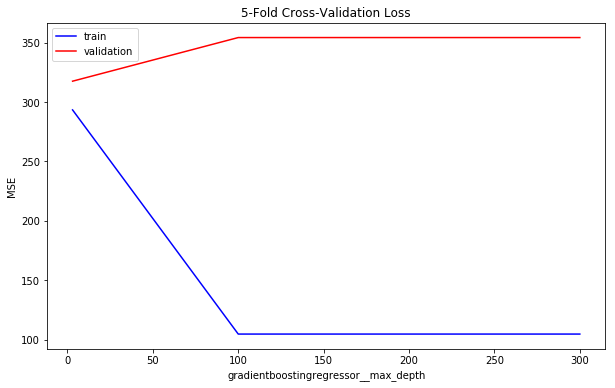

In [28]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2],
                                                         'gradientboostingregressor__min_samples_leaf':[200], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3,100,300], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__max_depth') 

#### Tune GradientBoostingRegressor *min_impurity_decrease* hyperparameter
- *min_impurity_decrease* specifies when a node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- GridSearch determined the optimal *min_impurity_decrease* value around 0.75. 

scores_train: [ 293.40668375  293.40668375  293.40668375]
scores_val: [ 317.57609285  317.57609285  317.57609285]
tuned optimal hyperparmeter: {'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__min_samples_leaf': 200, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_impurity_decrease': 0.75, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 317.576092853


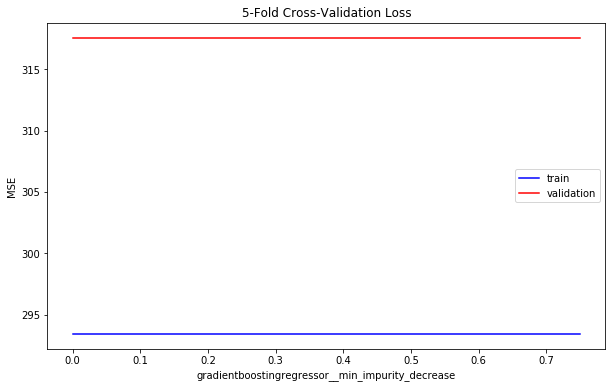

In [30]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2],
                                                         'gradientboostingregressor__min_samples_leaf':[200], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[0,.25,.75], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_impurity_decrease') 

#### Tune GradientBoostingRegressor hyperparameter *max_features*
- *max_features* specifies the number of features to consider when looking for the best split. Choosing *max_features* < *n_features* leads to a reduction of variance and an increase in bias
- GridSearch optimal *max_features* value was the default sklearn value *None*, i.e. using *max_features=n_estimators*.

scores_train: [ 316.42514007  294.75356899  293.40668375]
scores_val: [ 334.23351341  318.07933524  317.57609285]
tuned optimal hyperparmeter: {'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__min_samples_leaf': 200, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_impurity_decrease': 0.75, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 317.576092853


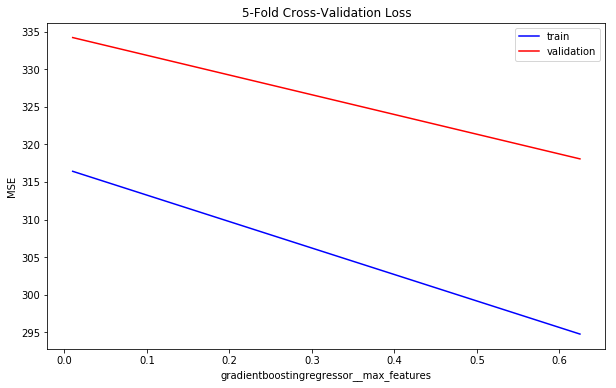

In [39]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2],
                                                         'gradientboostingregressor__min_samples_leaf':[200], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[.75], 
                                                         'gradientboostingregressor__max_features':[.01,.625,None],  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__max_features') 

#### Tune GradientBoostingRegressor hyperparameter *max_leaf_nodes*
- Grow trees with *max_leaf_nodes* in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- GridSearch found the default sklearn *max_leaf_nodes* value of *None* as optimal

scores_train: [ 341.8816116   276.36518388  276.36518388  293.40668375]
scores_val: [ 348.00720625  318.11308711  318.11308711  317.57609285]
tuned optimal hyperparmeter: {'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__max_leaf_nodes': None, 'gradientboostingregressor__min_samples_leaf': 200, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_impurity_decrease': 0.75, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 317.576092853


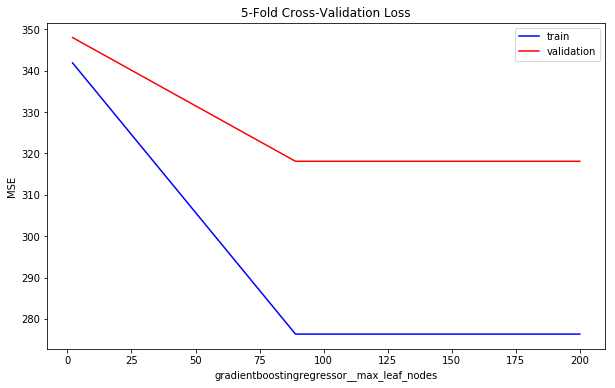

In [43]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2],
                                                         'gradientboostingregressor__min_samples_leaf':[200], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[.75], 
                                                         'gradientboostingregressor__max_features':[None],  
                                                         'gradientboostingregressor__max_leaf_nodes':[2,89,200,None],  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__max_leaf_nodes') 

#### Tune GradientBoostingRegressor *criterion* hyperparameter
- *criterion* specifies the function to measure the quality of a split. Supported criteria are “friedman_mse” for the mean squared error with improvement score by Friedman, “mse” for mean squared error, and “mae” for the mean absolute error. The default value of “friedman_mse” is generally the best as it can provide a better approximation in some cases.
- *friedman_mse* outperformed plain *mse*.


scores_train: [ 293.06215344  325.83943105]
scores_val: [ 317.7637335   333.50246291]
tuned optimal hyperparmeter: {'gradientboostingregressor__min_samples_leaf': 200, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__min_impurity_decrease': 0.75, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__criterion': 'friedman_mse', 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__max_leaf_nodes': None, 'gradientboostingregressor__n_estimators': 240, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__learning_rate': 0.2}
gridsearch best score: 317.763733505


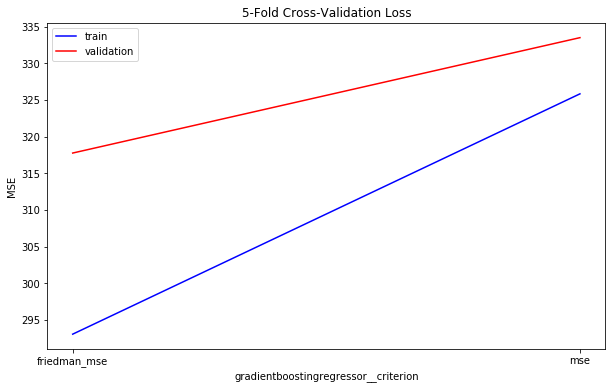

In [7]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.2],
                                                         'gradientboostingregressor__n_estimators':[240],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2],
                                                         'gradientboostingregressor__min_samples_leaf':[200], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[.75], 
                                                         'gradientboostingregressor__max_features':[None],  
                                                         'gradientboostingregressor__max_leaf_nodes':[None],  
                                                         'gradientboostingregressor__criterion':['friedman_mse','mse'],  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__criterion') 